In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import RandomSampler, Dataset, DataLoader

In [4]:
#demo using CIFAR10
#create dataset with pytorch datset and dataloaders
tf = transforms.Compose([
  torchvision.transforms.ToTensor(),
  transforms.Normalize([0.5]*3, [0.25]*3)
])
TRAIN_BATCH_SIZE = 128

trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=tf,
)
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, 
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=tf,
)
testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=200,
    shuffle=False, 
    num_workers=2
)

In [5]:
trainset.__len__()

50000

In [6]:
img, label = trainset.__getitem__(0)

### Setting up autoencoder

In [96]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, downsample=False, stride=1):
    super(ResidualBlock, self).__init__()
    self.downsample = downsample
    if self.downsample:
      padding = 0
      self.ds_pool = nn.AvgPool2d(kernel_size=kernel_size, stride=stride, padding=padding)
    else:
      padding = 1
    self.conv = nn.Sequential(
      nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
      nn.BatchNorm2d(num_features=out_channels),
      nn.ReLU(),
      nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
      nn.BatchNorm2d(num_features=out_channels)
    )
    self.relu = nn.ReLU()
    self.conv1x1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

  def forward(self, X):
    X_conv = self.conv(X)
    X = self.conv1x1(X)
    if self.downsample:
      X = self.ds_pool(X)
      X = self.ds_pool(X)
    X = X + X_conv
    X = self.relu(X)
    return X

In [153]:
class UnResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, in_shape, upsample=False, stride=1):
    super(UnResidualBlock, self).__init__()
    self.upsample = upsample
    if self.upsample:
      padding = 0
      size_increase1 = (in_shape - 1) * stride + kernel_size
      size_increase2 = (size_increase1 - 1) * stride + kernel_size
      self.up1 = nn.Upsample(size=size_increase1)
      self.up2 = nn.Upsample(size=size_increase2)
    else:
      padding = 1
    self.conv = nn.Sequential(
      nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
      nn.BatchNorm2d(num_features=out_channels),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
      nn.BatchNorm2d(num_features=out_channels)
    )
    self.relu = nn.ReLU()
    self.conv1x1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)

  def forward(self, X):
    X_conv = self.conv(X)
    X = self.conv1x1(X)
    if self.upsample:
      X = self.up1(X)
      X = self.up2(X)
    X = X + X_conv
    X = self.relu(X)
    return X

In [9]:
class ResNet(nn.Module):
  def __init__(self, dropout):
    super(ResNet, self).__init__()
    self.conv_init = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=0),
      nn.BatchNorm2d(num_features=4),
      nn.ReLU()
    )
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
    self.resblocks = nn.Sequential(
      ResidualBlock(in_channels=4, out_channels=8, kernel_size=4, downsample=True),
      ResidualBlock(in_channels=8, out_channels=16, kernel_size=4, downsample=True),
      ResidualBlock(in_channels=16, out_channels=32, kernel_size=4, downsample=True),
      ResidualBlock(in_channels=32, out_channels=64, kernel_size=4, downsample=True),
      ResidualBlock(in_channels=64, out_channels=128, kernel_size=2, downsample=True),
      nn.Dropout(dropout),
    )
    self.final_layer = nn.Sequential(
      nn.AvgPool2d(kernel_size=3, padding=0, stride=1),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(in_features=128, out_features=64, bias=False),
    )
  
  def forward(self, X):
    X = self.conv_init(X)
    X = self.maxpool(X)
    X = self.resblocks(X)
    X = self.final_layer(X)
    return X

In [112]:
class UnResNet(nn.Module):
  def __init__(self, dropout):
    super(UnResNet, self).__init__()
    self.unproject = nn.Sequential(
      nn.Linear(in_features=64, out_features=128),
      nn.Unflatten(dim=-1, unflattened_size=[128, 1, 1]),
      nn.ReLU(),
      nn.Upsample(size=3),
    )
    self.unresblocks = nn.Sequential(
      nn.Dropout(dropout),
      UnResidualBlock(in_channels=128, out_channels=64, kernel_size=2, in_shape=3, upsample=True),
      UnResidualBlock(in_channels=64, out_channels=32, kernel_size=4, in_shape=5, upsample=True),
      UnResidualBlock(in_channels=32, out_channels=16, kernel_size=4, in_shape=11, upsample=True),
      UnResidualBlock(in_channels=16, out_channels=8, kernel_size=4, in_shape=17, upsample=True),
      UnResidualBlock(in_channels=8, out_channels=4, kernel_size=4, in_shape=23, upsample=True), 
    )
    self.rev_maxpool = nn.Upsample(size=30)
    self.rev_conv_init = nn.Sequential(
      nn.ReLU(),
      nn.BatchNorm2d(num_features=4),
      nn.ConvTranspose2d(in_channels=4, out_channels=3, kernel_size=3, stride=1, padding=0),       
    )

  def forward(self, X):
    X = self.unproject(X)
    X = self.unresblocks(X)
    X = self.rev_maxpool(X)
    X = self.rev_conv_init(X)
    return X

In [11]:
class ResNetAutoEncoder(nn.Module):
  def __init__(self, dropout=0.2):
    super(ResNetAutoEncoder, self).__init__()
    self.resnet = ResNet(dropout)
    self.unresnet = UnResNet(dropout)
  
  def forward(self, X):
    X_emb = self.resnet(X) #embed X
    X_repr = self.unresnet(X_emb) #reproduce X
    return X_emb, X_repr

### Train 

In [12]:
device = torch.device('xpu')
rnae = ResNetAutoEncoder()
rnae.to(device)
sum([p.numel() for p in rnae.parameters()])

384475

In [13]:
batch, _ = next(iter(trainloader))
batch = batch.to(device)
batch_emb, batch_repr = rnae(batch)
batch.shape, batch_emb.shape, batch_repr.shape

(torch.Size([128, 3, 32, 32]),
 torch.Size([128, 64]),
 torch.Size([128, 3, 32, 32]))

In [14]:
criterion = nn.MSELoss()
lr = 1e-3
weight_decay = 1e-3
optimizer = optim.Adam(params=rnae.parameters(), lr=lr, weight_decay=1e-3)

In [15]:
for epoch in range(10):
  for idx, (inputs, _) in enumerate(testloader, 0):
    inputs = inputs.to(device)
    emb, repr = rnae(inputs)
    optimizer.zero_grad()
    loss = criterion(repr, inputs)
    loss.backward()
    optimizer.step()

    if idx % 20 == 0:
      print(f'epoch {epoch}, batch {idx}: loss = {loss.item()}')


epoch 0, batch 0: loss = 1.4183911085128784
epoch 0, batch 20: loss = 1.0150094032287598
epoch 0, batch 40: loss = 0.7885667085647583
epoch 1, batch 0: loss = 0.7109338641166687
epoch 1, batch 20: loss = 0.6728948950767517
epoch 1, batch 40: loss = 0.6118177175521851
epoch 2, batch 0: loss = 0.6054090261459351
epoch 2, batch 20: loss = 0.6069345474243164
epoch 2, batch 40: loss = 0.5716887712478638
epoch 3, batch 0: loss = 0.5645923614501953
epoch 3, batch 20: loss = 0.5633751153945923
epoch 3, batch 40: loss = 0.5396621823310852
epoch 4, batch 0: loss = 0.5333914756774902
epoch 4, batch 20: loss = 0.542475163936615
epoch 4, batch 40: loss = 0.515641987323761
epoch 5, batch 0: loss = 0.5070582032203674
epoch 5, batch 20: loss = 0.5075738430023193
epoch 5, batch 40: loss = 0.48354461789131165
epoch 6, batch 0: loss = 0.48172980546951294
epoch 6, batch 20: loss = 0.492007315158844
epoch 6, batch 40: loss = 0.46936696767807007
epoch 7, batch 0: loss = 0.4670346677303314
epoch 7, batch 20:

### Demonstrate embeddings with clustering

In [16]:
sampler = RandomSampler(trainset)
sampling_dataloader = DataLoader(trainset, batch_size=100, sampler=sampler)

In [180]:
def compare_cos_similarity(model, sampling_dataloader, device):
  x, y = next(iter(sampling_dataloader))
  x, y = x.to(device), y.to(device)
  x_emb, _ = model(x)

  x_emb_norm = F.normalize(x_emb.squeeze(1), p=2.0, dim=1)
  cos_sim = x_emb_norm @ x_emb_norm.T
  cos_sim = (cos_sim.cpu() + 1) / 2 #add one and divide by 2 so that values range from 0 to 1, not -1 to 1 

  y_cpu = y.cpu()
  print('class    |  same class  |  diff class  |  ratio (same / diff)')
  print('-------------------------------------------------------------')
  for label in set(y_cpu.numpy()):
    idxs = (y_cpu == label).nonzero().squeeze(1)
    not_idxs = (y_cpu != label).nonzero().squeeze(1)
    mean_dot_prod_sharedclass = cos_sim[idxs][:, idxs].mean()
    mean_dot_prod_diffclass = cos_sim[idxs][:, not_idxs].mean()
    ratio = mean_dot_prod_sharedclass / mean_dot_prod_diffclass
    print(f'class {label}        {mean_dot_prod_sharedclass:.2f}           {mean_dot_prod_diffclass:.2f}          {ratio:.2f}')

In [169]:
compare_cos_similarity(rnae, testloader)

class    |  same class  |  diff class  |  ratio (same / diff)
-------------------------------------------------------------
class 0        0.16           0.04          3.63
class 1        0.19           0.08          2.31
class 2        0.10           0.07          1.36
class 3        0.20           0.07          2.68
class 4        0.14           0.08          1.70
class 5        0.13           0.07          1.95
class 6        0.35           0.08          4.55
class 7        0.10           0.06          1.78
class 8        0.25           0.02          15.30
class 9        0.28           0.06          5.06


In [26]:
untrained_rnae = ResNetAutoEncoder().to(device)
compare_cos_similarity(untrained_rnae, testloader)

class    |  same class  |  diff class  |  ratio (same / diff)
-------------------------------------------------------------
class 0        0.49           0.50          0.99
class 1        0.52           0.49          1.06
class 2        0.49           0.50          0.99
class 3        0.59           0.54          1.10
class 4        0.61           0.54          1.13
class 5        0.58           0.53          1.08
class 6        0.52           0.50          1.04
class 7        0.53           0.52          1.02
class 8        0.60           0.53          1.14
class 9        0.58           0.53          1.09


In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)

x, y = next(iter(sampling_dataloader))
x, y = x.to(device), y.to(device)
x_emb, _ = rnae(x)

In [21]:
x_pca = pca.fit_transform(x_emb.cpu().detach().numpy())

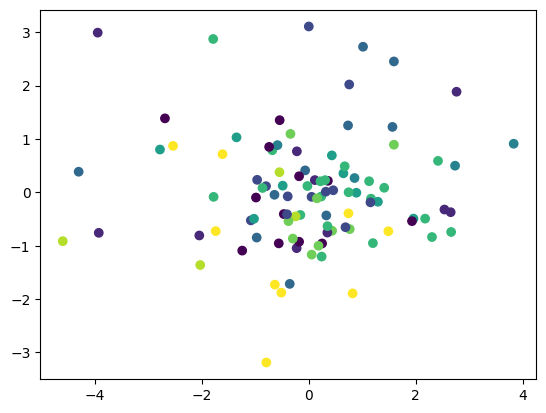

In [22]:
plt.scatter(x=x_pca[:, 0], y=x_pca[:, 1], c=y.cpu())

### Same Approach, but on MNIST

In [28]:
from torchvision import datasets, transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize pixel values
])
mnist_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=1000, shuffle=False)

In [154]:
class MnistResNet(nn.Module):
  def __init__(self):
    super(MnistResNet, self).__init__()
    self.conv_init = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=0),
      nn.BatchNorm2d(num_features=2),
      nn.ReLU()
    )
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
    self.resblocks = nn.Sequential(
      ResidualBlock(in_channels=2, out_channels=4, kernel_size=3, downsample=True),
      ResidualBlock(in_channels=4, out_channels=8, kernel_size=3, downsample=True),
      ResidualBlock(in_channels=8, out_channels=16, kernel_size=3, downsample=True),
      ResidualBlock(in_channels=16, out_channels=32, kernel_size=3, downsample=True),
      ResidualBlock(in_channels=32, out_channels=64, kernel_size=3, downsample=True),
      ResidualBlock(in_channels=64, out_channels=128, kernel_size=3, downsample=True),
    )
    self.final_layer = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=128, out_features=32, bias=False),
    )
  
  def forward(self, X):
    X = self.conv_init(X)
    X = self.maxpool(X)
    X = self.resblocks(X)
    X = self.final_layer(X)
    return X

In [155]:
class MnistUnResNet(nn.Module):
  def __init__(self):
    super(MnistUnResNet, self).__init__()
    self.unproject = nn.Sequential(
      nn.Linear(in_features=32, out_features=128),
      nn.Unflatten(dim=-1, unflattened_size=[128, 1, 1]),
    )
    self.unresblocks = nn.Sequential(
      UnResidualBlock(in_channels=128, out_channels=64, kernel_size=3, in_shape=1, upsample=True),
      UnResidualBlock(in_channels=64, out_channels=32, kernel_size=3, in_shape=5, upsample=True),
      UnResidualBlock(in_channels=32, out_channels=16, kernel_size=3, in_shape=9, upsample=True),
      UnResidualBlock(in_channels=16, out_channels=8, kernel_size=3, in_shape=13, upsample=True),
      UnResidualBlock(in_channels=8, out_channels=4, kernel_size=3, in_shape=17, upsample=True),
      UnResidualBlock(in_channels=4, out_channels=2, kernel_size=3, in_shape=21, upsample=True),
    )
    self.rev_maxpool = nn.Upsample(size=26)
    self.rev_conv_init = nn.Sequential(
      nn.ReLU(),
      nn.BatchNorm2d(num_features=2),
      nn.ConvTranspose2d(in_channels=2, out_channels=1, kernel_size=3, stride=1, padding=0),       
    )

  def forward(self, X):
    X = self.unproject(X)
    X = self.unresblocks(X)
    X = self.rev_maxpool(X)
    X = self.rev_conv_init(X)
    return X

In [188]:
class MnistResNetAutoEncoder(nn.Module):
  def __init__(self):
    super(MnistResNetAutoEncoder, self).__init__()
    self.resnet = MnistResNet()
    self.unresnet = MnistUnResNet()
  
  def forward(self, X):
    X_emb = self.resnet(X) #embed X
    X_repr = self.unresnet(X_emb) #reproduce X
    return X_emb, X_repr
  
mrnae = MnistResNetAutoEncoder()
mrnae.to(device)
sum([p.numel() for p in mrnae.parameters()])

475113

In [189]:
#train
criterion = nn.MSELoss()
lr = 1e-3
weight_decay = 1e-3
optimizer = optim.Adam(params=mrnae.parameters(), lr=lr, weight_decay=1e-3)


for epoch in range(5):
  for idx, (inputs, _) in enumerate(mnist_train_loader, 0):
    inputs = inputs.to(device)
    emb, repr = mrnae(inputs)
    optimizer.zero_grad()
    loss = criterion(repr, inputs)
    loss.backward()
    optimizer.step()

    if idx % 200 == 0:
      print(f'epoch {epoch}, batch {idx}: loss = {loss.item()}')

epoch 0, batch 0: loss = 1.5999789237976074
epoch 0, batch 400: loss = 0.3096774220466614
epoch 0, batch 800: loss = 0.21471326053142548
epoch 1, batch 0: loss = 0.20442704856395721
epoch 1, batch 400: loss = 0.1940455436706543
epoch 1, batch 800: loss = 0.19657453894615173
epoch 2, batch 0: loss = 0.18291908502578735
epoch 2, batch 400: loss = 0.19517071545124054
epoch 2, batch 800: loss = 0.1605585515499115
epoch 3, batch 0: loss = 0.16305595636367798
epoch 3, batch 400: loss = 0.1685318797826767
epoch 3, batch 800: loss = 0.1559986025094986
epoch 4, batch 0: loss = 0.15028521418571472
epoch 4, batch 400: loss = 0.14003030955791473
epoch 4, batch 800: loss = 0.16884569823741913


In [242]:
compare_cos_similarity(mrnae, mnist_test_loader, device)

class    |  same class  |  diff class  |  ratio (same / diff)
-------------------------------------------------------------
class 0        0.69           0.55          1.26
class 1        0.75           0.53          1.42
class 2        0.68           0.56          1.21
class 3        0.67           0.55          1.20
class 4        0.67           0.56          1.19
class 5        0.63           0.55          1.15
class 6        0.68           0.56          1.23
class 7        0.67           0.55          1.22
class 8        0.65           0.56          1.15
class 9        0.69           0.56          1.22


In [191]:
untrained_mrnae = MnistResNetAutoEncoder()
untrained_mrnae.to(device)

compare_cos_similarity(untrained_mrnae, mnist_test_loader, device)

class    |  same class  |  diff class  |  ratio (same / diff)
-------------------------------------------------------------
class 0        0.69           0.69          1.01
class 1        0.69           0.68          1.02
class 2        0.70           0.70          1.01
class 3        0.72           0.71          1.02
class 4        0.73           0.71          1.03
class 5        0.72           0.70          1.02
class 6        0.72           0.70          1.02
class 7        0.69           0.69          1.00
class 8        0.73           0.71          1.04
class 9        0.72           0.70          1.02


### Demonstraiton on several examples

In [208]:
x, y = next(iter(mnist_train_loader))
img_emb, img_repr = mrnae(x.to(device))

tensor(9)


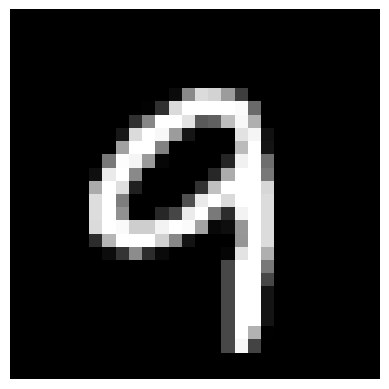

In [240]:
idx = 10

print(y[idx])
plt.imshow(x[idx].squeeze(0), cmap='gray')
plt.axis('off')
plt.savefig('9_ae_compare_in.png', bbox_inches='tight', pad_inches=0)
plt.show()

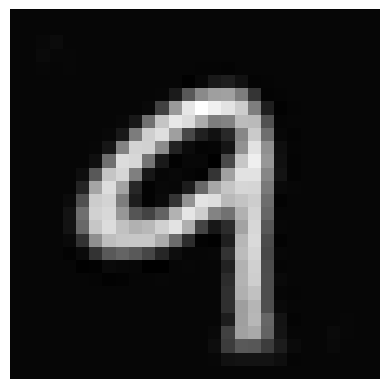

In [241]:
plt_img = img_repr[idx].squeeze(0).cpu().detach().numpy()
plt.imshow(plt_img, cmap='gray')
plt.axis('off')
plt.savefig('9_ae_compare_out.png', bbox_inches='tight', pad_inches=0)
plt.show()